In [1]:
# import pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

print(torch.__version__)


2.2.1+cu121


In [2]:
# Optional to run code on GPU
# Check if CUDA is available and if device is GPU
print('Cuda Available : {}'.format(torch.cuda.is_available()))
print('GPU - {0}'.format(torch.cuda.get_device_name()))

# Note:
# If this gives you an error on Google colab, go into 'Additional connection otions' > 'Change runtime type' > Select a GPU as the Hardware Accelerator
# If you're running code on your machine locally, your machine needs have a GPU supported graphics card and CUDA installed.

Cuda Available : False


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

### Here's a great beginner tutorial for reference on how to train a classifier with PyTorch on image data: [Training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

# Q3

In [3]:
# Load MNIST dataset
mnist_train = datasets.MNIST('data', train=True, download=True)
mnist_test = datasets.MNIST('data', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 145949334.57it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 12386062.76it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37751735.30it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12820005.90it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



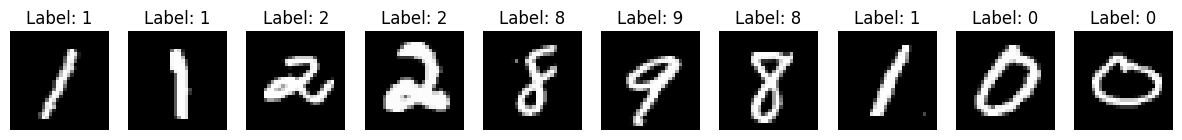

In [4]:
# visualise the dataset

import matplotlib.pyplot as plt

# Define a function to visualize images and their labels
def visualize_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        idx = np.random.randint(0, len(dataset))
        image, label = dataset[idx]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Visualize samples from the training set
visualize_samples(mnist_train)

In [5]:
# Check MNIST statistics
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(mnist_train.data.min(), mnist_train.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(mnist_train.data.float().mean(), mnist_train.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(mnist_train.data.float().mean() / 255, mnist_train.data.float().std() / 255))

Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.31842041015625 
Pixel Values Std: 78.56748962402344
Scaled Mean Pixel Value 0.13066047430038452 
Scaled Pixel Values Std: 0.30810779333114624


In [6]:
# normalize and prepare data for training the model

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the pixel values
])

# TODO: Load MNIST training dataset with transformations
mnist_train = datasets.MNIST('data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('data', train=False, download=True, transform=transform)

# TODO: Split dataset into training, validation, and test sets
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
minst_train, mnist_val = random_split(mnist_train, [train_size, val_size])

# TODO: Define data loaders
train_loader = DataLoader(mnist_train, batch_size = 500, shuffle = True)
val_loader = DataLoader(mnist_val, batch_size = 500)
test_loader = DataLoader(mnist_train, batch_size = 500)

In [7]:
# TODO: Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        #TODO: define the layers of the model here
        self.flatten = nn.Flatten() #Input layer

        #Hidden Layer(s)
        self.fc1 = nn.Linear(28*28, 512)  #Hidden layer 1
        self.fc2 = nn.Linear(512, 256)    #Hidden layer 2

        #Output Layer
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        #TODO: pass the data through each layer of the model here
        x= self.flatten(x)
        x = torch.relu(self.fc1(x)) #hidden layer 1 relu activation function
        x = torch.relu(self.fc2(x)) #hidden layer 1 relu activation layer
        x= self.output(x)
        return x

In [8]:
!pip install tqdm

In [9]:
from tqdm import tqdm

# Initialize model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP().to(device)

# TODO: Define the following for your model
# loss function
loss_fnt = nn.CrossEntropyLoss()


# learning rate
# optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-4)  #trial end error optimisers, random learning rate(lr)
# number of epochs to train the model
num_epochs = 10

# Lists to store the loss and accuracy values
train_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
  model.train()
  correct = 0
  total = 0
  running_loss = 0
  # TODO: train the model
  # get the inputs from train data loader
  for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc = f"Epoch {epoch+1}")):
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass through the model
    outputs = model(data.to(device))
    # backward propagation + optimize
    loss = loss_fnt(outputs, targets.to(device))
    loss.backward()
    optimizer.step()
    outputs = model(data.to(device))
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu()
    total += targets.size(0)
    correct += (predicted == targets).sum().item()
    # calculate statistics
    running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)



    # TODO: Validate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      # get inputs from validation data loader
      for data,targets in val_loader:
        # forward pass + get predicted outputs
        outputs = model(data.to(device))  #Forward pass
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu()
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    # calculate accuracy of predictions
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
  # print statistics
  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')



Epoch 1: 100%|██████████| 120/120 [06:53<00:00,  3.45s/it]


Epoch 1/10, Loss: 2.3114, Training Accuracy: 10.46%, Validation Accuracy: 10.56%


Epoch 2: 100%|██████████| 120/120 [06:33<00:00,  3.28s/it]


Epoch 2/10, Loss: 2.3070, Training Accuracy: 11.18%, Validation Accuracy: 11.16%


Epoch 3: 100%|██████████| 120/120 [07:08<00:00,  3.57s/it]


Epoch 3/10, Loss: 2.3027, Training Accuracy: 11.74%, Validation Accuracy: 11.78%


Epoch 4: 100%|██████████| 120/120 [06:22<00:00,  3.19s/it]


Epoch 4/10, Loss: 2.2984, Training Accuracy: 12.32%, Validation Accuracy: 12.39%


Epoch 5: 100%|██████████| 120/120 [06:21<00:00,  3.18s/it]


Epoch 5/10, Loss: 2.2941, Training Accuracy: 13.25%, Validation Accuracy: 13.20%


Epoch 6: 100%|██████████| 120/120 [06:25<00:00,  3.22s/it]


Epoch 6/10, Loss: 2.2898, Training Accuracy: 13.96%, Validation Accuracy: 13.96%


Epoch 7: 100%|██████████| 120/120 [06:32<00:00,  3.27s/it]


Epoch 7/10, Loss: 2.2855, Training Accuracy: 14.70%, Validation Accuracy: 14.82%


Epoch 8: 100%|██████████| 120/120 [06:27<00:00,  3.23s/it]


Epoch 8/10, Loss: 2.2812, Training Accuracy: 15.65%, Validation Accuracy: 15.67%


Epoch 9: 100%|██████████| 120/120 [06:23<00:00,  3.20s/it]


Epoch 9/10, Loss: 2.2769, Training Accuracy: 16.90%, Validation Accuracy: 16.87%


Epoch 10: 100%|██████████| 120/120 [06:25<00:00,  3.22s/it]

Epoch 10/10, Loss: 2.2726, Training Accuracy: 17.91%, Validation Accuracy: 17.94%


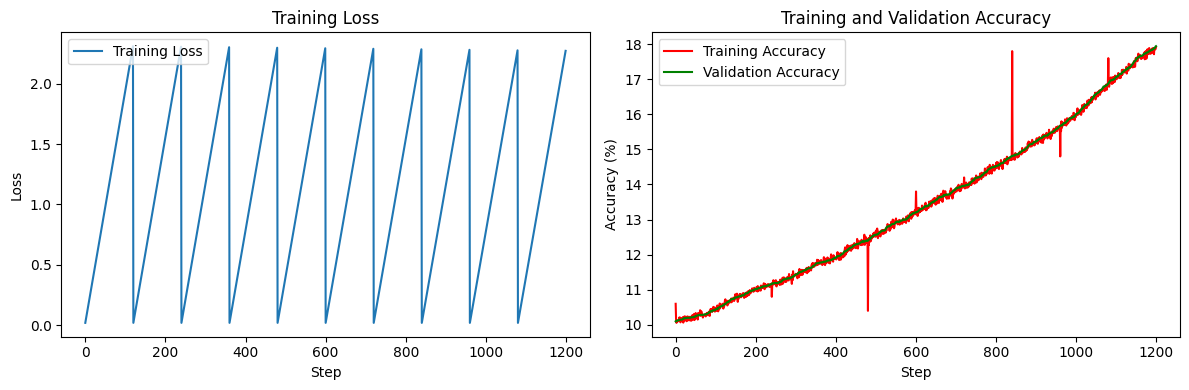

In [10]:
# TODO: Show loss and accuracy plots

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='r')
plt.plot(val_accuracies, label='Validation Accuracy', color='g')
plt.xlabel('Step')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# TODO: Evaluate the model on the test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
  # get inputs from test data loader
  for data,targets in test_loader:
    # forward pass + get predicted outputs
    outputs = model(data.to(device))  #Forward pass
    _, predicted = torch.max(outputs, 1)
    predicted = predicted.cpu()
    total += targets.size(0)
    correct += (predicted == targets).sum().item()
# calculate accuracy of predictions
test_accuracy = 100 * correct / total
# print statistics
print(f'Test Accuracy: {test_accuracy:.2f}%') # Test Accuracy: 77.82%

Test Accuracy: 17.61%


# Q4

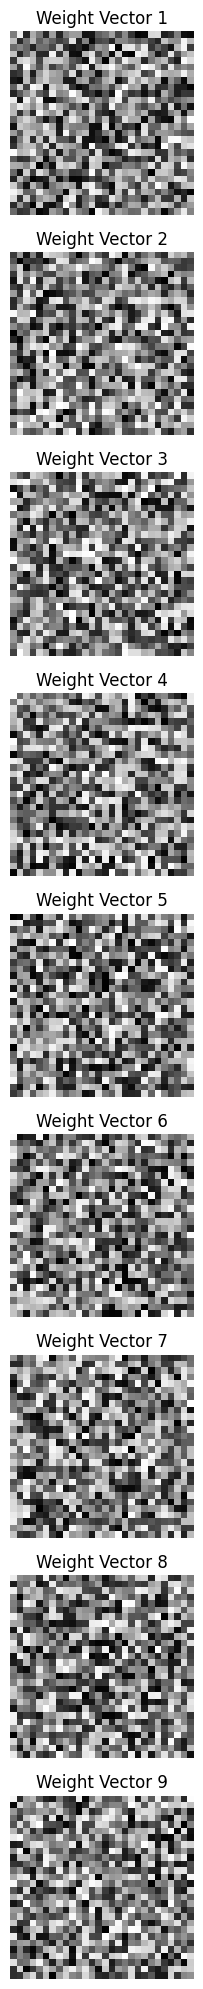

In [13]:
# TODO: Extract the weight matrix of the first hidden layer
weight_matrix = model.fc1.weight.data.cpu().numpy()

# TODO: Normalize each row of the weight matrix to [0, 1]
normalized_weight_matrix = (weight_matrix - weight_matrix.min(axis=1, keepdims=True)) / (weight_matrix.max(axis=1, keepdims=True) - weight_matrix.min(axis=1, keepdims=True))

# Visualize the first 9 rows of the normalized weight matrix
num_rows_to_visualize = 9
fig, axes = plt.subplots(num_rows_to_visualize, 1, figsize=(10, 20))
for i in range(num_rows_to_visualize):
    axes[i].imshow(normalized_weight_matrix[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Weight Vector {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()